In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

chessboard_size = (9, 6)
frame_size = (640, 480)

# 设置棋盘格点的世界坐标
objp = np.zeros((chessboard_size[0]*chessboard_size[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
square_size = 1
objp *= square_size

# 用于存储世界坐标和图像坐标
objpoints = [] # 3d points in real world space
imgpoints_main = [] # 2d points in image plane

images = glob.glob('demo/left*.jpg')
images = sorted(images)
print(f"Found {len(images)} images for calibration")


for idx, image_file in enumerate(images):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret == True:
        objpoints.append(objp)

        # 亚像素级角点精确化
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_main.append(corners2)
        
    else:
        print(f"Chessboard corners not found in image: {image_file}")

# 相机标定
ret_main, mtx_main, dist_main, rvecs_main, tvecs_main = cv2.calibrateCamera(objpoints, imgpoints_main, frame_size, None, None)
mtx_main, roiL = cv2.getOptimalNewCameraMatrix(mtx_main, dist_main,frame_size, 0)

print(ret_main)
# 0.13074811398820754

# 用于存储世界坐标和图像坐标
imgpoints_side = [] # 2d points in image plane.

images = glob.glob('demo/right*.jpg')
images = sorted(images)
print(f"Found {len(images)} images for calibration")


for idx, image_file in enumerate(images):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret == True:

        # 亚像素级角点精确化
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_side.append(corners2)
        
    else:
        print(f"Chessboard corners not found in image: {image_file}")


# 相机标定
ret_side, mtx_side, dist_side, rvecs_side, tvecs_side = cv2.calibrateCamera(objpoints, imgpoints_side, frame_size, None, None)
mtx_side, roiL = cv2.getOptimalNewCameraMatrix(mtx_side, dist_side,frame_size, 0)

print(ret_side)
# 0.14812752595046502

# 双目相机标定
# flags 参数
# flags参数用于控制双目标定过程中的不同选项。常见的标志包括：

# cv2.CALIB_FIX_INTRINSIC：在标定过程中保持两个相机的内参数矩阵不变。这意味着在双目标定过程中不会重新估计每个相机的内参数矩阵（包括焦距、光轴中心等），而是使用单个相机标定结果中得到的内参数。
# cv2.CALIB_USE_INTRINSIC_GUESS：使用传入的内参数作为初始猜测值，并在标定过程中对其进行优化。这对提高标定精度很有帮助，特别是在内参数已经较准确的情况下。
# cv2.CALIB_FIX_PRINCIPAL_POINT：保持主点（光轴中心）固定不变。
# cv2.CALIB_FIX_FOCAL_LENGTH：保持焦距不变。
# cv2.CALIB_FIX_ASPECT_RATIO：保持焦距的长宽比不变。
# cv2.CALIB_ZERO_TANGENT_DIST：假设切向畸变参数为零并保持不变。
# cv2.CALIB_RATIONAL_MODEL：使标定函数使用一个带有6个畸变系数的合理模型。
# cv2.CALIB_SAME_FOCAL_LENGTH：假设两个摄像头具有相同的焦距。
# criteria 参数
# criteria参数定义了优化算法的终止条件，即在何种情况下停止迭代优化。它是一个包含两个元素的元组：

# 类型：终止条件的类型，可以是以下值的组合：

# cv2.TERM_CRITERIA_MAX_ITER：当达到最大迭代次数时停止。
# cv2.TERM_CRITERIA_EPS：当参数变化小于设定的精度时停止。
# 可以组合使用，例如cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS，表示当满足任意一个条件时停止。
# 最大迭代次数：一个整数，指定最大迭代次数。例如，100表示最多迭代100次。

# 精度阈值：一个浮点数，指定参数变化小于该值时停止迭代。例如，1e-5表示当参数变化小于0.00001时停止迭代。

flags = cv2.CALIB_FIX_INTRINSIC
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 100, 1e-6)
ret, mtx_main, dist_main, mtx_side, dist_side, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_main, imgpoints_side,
    mtx_main, dist_main, mtx_side, dist_side,
    frame_size, criteria=criteria, flags=flags)

# 立体校正
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtx_main, dist_main, mtx_side, dist_side, frame_size, R, T)

print(ret)

Found 41 images for calibration
0.4079886660635017
Found 41 images for calibration
0.4069743323540327
1.2170125436571109


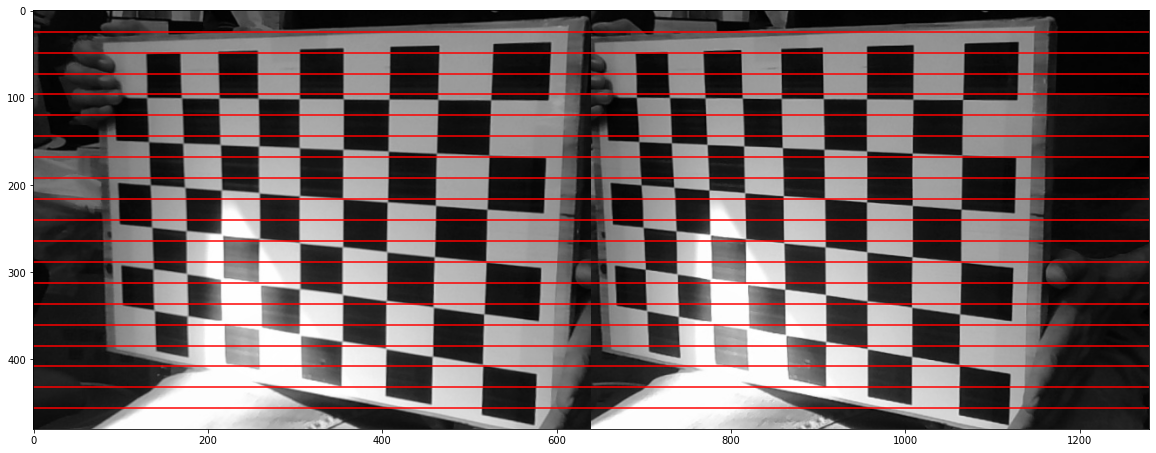

In [3]:
# 对测试图像进行校正
def rectify_image(img, mtx, dist, R, P):
    h, w = img.shape[:2]
    mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, R, P, (w, h), cv2.CV_32FC1)
    return cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

# 读取测试图片
img_main = cv2.imread('demo/left03.jpg')
img_side = cv2.imread('demo/right03.jpg')

# 校正图像
rectified_main = rectify_image(img_main, mtx_main, dist_main, R1, P1)
rectified_side = rectify_image(img_side, mtx_side, dist_side, R2, P2)

# 保存校正后的图像
cv2.imwrite('rectified_main.png', rectified_main)
cv2.imwrite('rectified_side.png', rectified_side)

plt.figure(figsize=(20, 20))

for i in range(0,1):  # 以第一对图片为例
    im_L=Image.fromarray(rectified_main) # numpy 转 image类
    im_R=Image.fromarray(rectified_side) # numpy 转 image 类

    width = im_L.size[0]*2
    height = im_L.size[1]

    img_compare = Image.new('RGBA',(width, height))
    img_compare.paste(im_L,box=(0,0))
    img_compare.paste(im_R,box=(640,0))
    
    #在已经极线对齐的图片上均匀画线
    for i in range(1,20):
        len=480/20
        plt.axhline(y=i*len, color='r', linestyle='-')
    plt.imshow(img_compare)
    plt.savefig('epipolar_lines.png', bbox_inches='tight', pad_inches=0)
    plt.show()

Found 20 images for calibration
0.5069502464191885
Found 20 images for calibration
0.49274672763604005
91.4733003419118


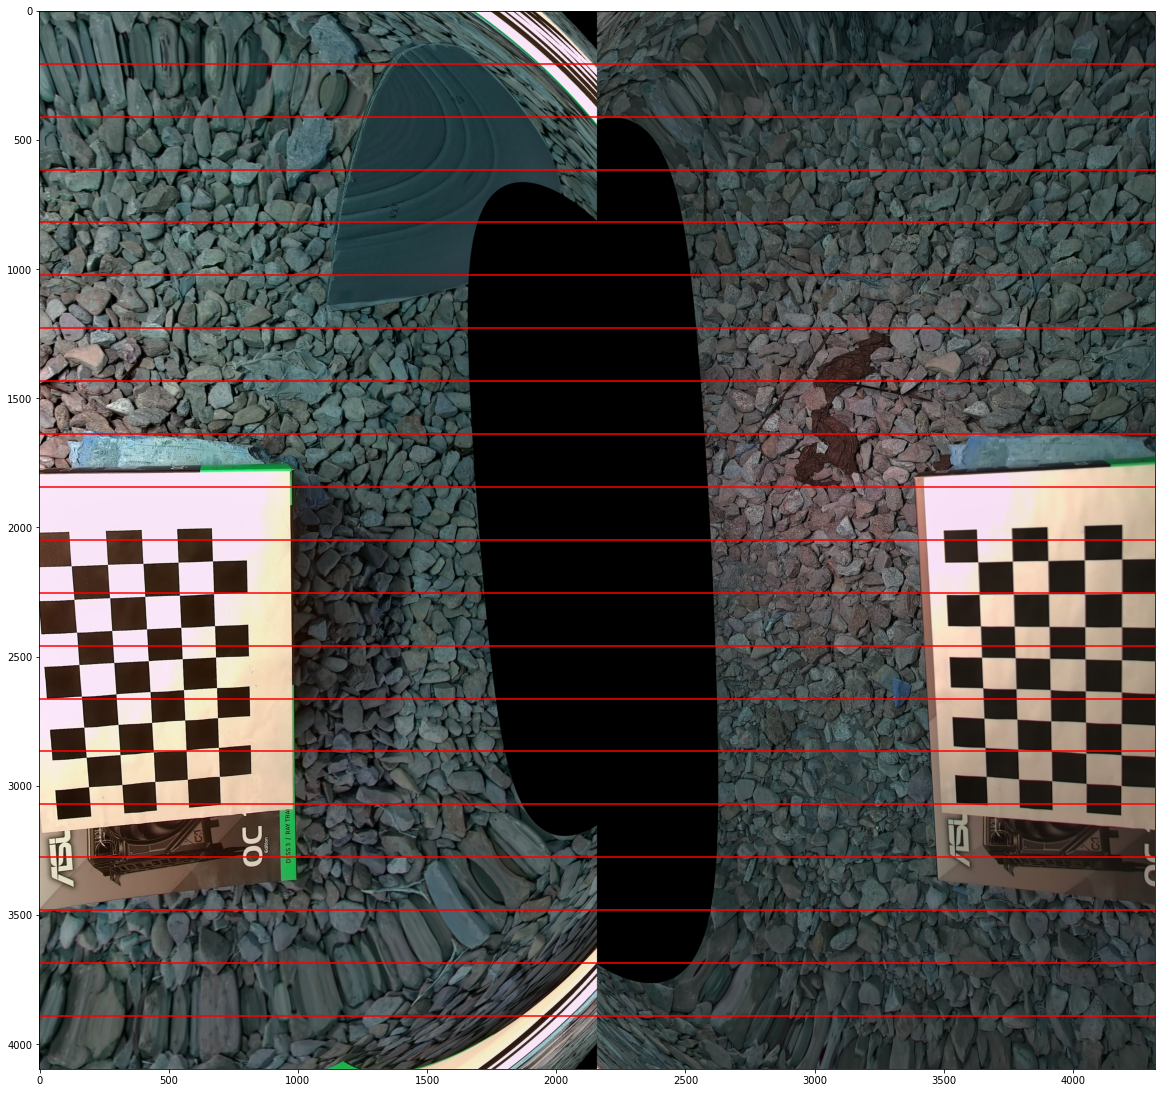

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

chessboard_size = (5, 8)
frame_size = (2160, 4096)
# chessboard_size = (4, 7)
# frame_size = (1280, 720)

# 设置棋盘格点的世界坐标
objp = np.zeros((chessboard_size[0]*chessboard_size[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
square_size = 2.7
# square_size = 1
objp *= square_size

# 用于存储世界坐标和图像坐标
objpoints = [] # 3d points in real world space
imgpoints_main = [] # 2d points in image plane

images = glob.glob('main/150_*.jpg')
# images = glob.glob('D2/*.png') 

print(f"Found {len(images)} images for calibration")


for idx, image_file in enumerate(images):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.rotate(gray, cv2.ROTATE_90_CLOCKWISE)
# for frame in images:
#     gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret == True:
        objpoints.append(objp)

        # 亚像素级角点精确化
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_main.append(corners2)
        
    else:
        print(f"Chessboard corners not found in image: {image_file}")

# 相机标定
ret_main, mtx_main, dist_main, rvecs_main, tvecs_main = cv2.calibrateCamera(objpoints, imgpoints_main, frame_size, None, None)

# 保存标定结果
np.savez('camera_calibration.npz', camera_matrix=mtx_main, dist_coeffs=dist_main, rvecs=rvecs_main, tvecs=tvecs_main)

print(ret_main)
# 0.13074811398820754

# 用于存储世界坐标和图像坐标
imgpoints_side = [] # 2d points in image plane.

images = glob.glob('side/151_*.jpg')
# images = glob.glob('J2/*.png')
print(f"Found {len(images)} images for calibration")


for idx, image_file in enumerate(images):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.rotate(gray, cv2.ROTATE_90_CLOCKWISE)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret == True:

        # 亚像素级角点精确化
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_side.append(corners2)
        
    else:
        print(f"Chessboard corners not found in image: {image_file}")


# 相机标定
ret_side, mtx_side, dist_side, rvecs_side, tvecs_side = cv2.calibrateCamera(objpoints, imgpoints_side, frame_size, None, None)

# 保存标定结果
np.savez('camera_calibration.npz', camera_matrix=mtx_side, dist_coeffs=dist_side, rvecs=rvecs_side, tvecs=tvecs_side)

print(ret_side)
# 0.14812752595046502

# 双目相机标定
# flags 参数
# flags参数用于控制双目标定过程中的不同选项。常见的标志包括：

# cv2.CALIB_FIX_INTRINSIC：在标定过程中保持两个相机的内参数矩阵不变。这意味着在双目标定过程中不会重新估计每个相机的内参数矩阵（包括焦距、光轴中心等），而是使用单个相机标定结果中得到的内参数。
# cv2.CALIB_USE_INTRINSIC_GUESS：使用传入的内参数作为初始猜测值，并在标定过程中对其进行优化。这对提高标定精度很有帮助，特别是在内参数已经较准确的情况下。
# cv2.CALIB_FIX_PRINCIPAL_POINT：保持主点（光轴中心）固定不变。
# cv2.CALIB_FIX_FOCAL_LENGTH：保持焦距不变。
# cv2.CALIB_FIX_ASPECT_RATIO：保持焦距的长宽比不变。
# cv2.CALIB_ZERO_TANGENT_DIST：假设切向畸变参数为零并保持不变。
# cv2.CALIB_RATIONAL_MODEL：使标定函数使用一个带有6个畸变系数的合理模型。
# cv2.CALIB_SAME_FOCAL_LENGTH：假设两个摄像头具有相同的焦距。
# criteria 参数
# criteria参数定义了优化算法的终止条件，即在何种情况下停止迭代优化。它是一个包含两个元素的元组：

# 类型：终止条件的类型，可以是以下值的组合：

# cv2.TERM_CRITERIA_MAX_ITER：当达到最大迭代次数时停止。
# cv2.TERM_CRITERIA_EPS：当参数变化小于设定的精度时停止。
# 可以组合使用，例如cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS，表示当满足任意一个条件时停止。
# 最大迭代次数：一个整数，指定最大迭代次数。例如，100表示最多迭代100次。

# 精度阈值：一个浮点数，指定参数变化小于该值时停止迭代。例如，1e-5表示当参数变化小于0.00001时停止迭代。

flags = cv2.CALIB_FIX_INTRINSIC
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 100, 1e-6)
ret, mtx_main, dist_main, mtx_side, dist_side, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_main, imgpoints_side,
    mtx_main, dist_main, mtx_side, dist_side,
    frame_size, criteria=criteria, flags=flags)

# 立体校正
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtx_main, dist_main, mtx_side, dist_side, frame_size, R, T)

print(ret)

# 对测试图像进行校正
def rectify_image(img, mtx, dist, R, P):
    h, w = img.shape[:2]
    mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, R, P, (w, h), cv2.CV_32FC1)
    return cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

# 读取测试图片
img_main = cv2.imread('main/150_1.jpg')
img_main = cv2.rotate(img_main, cv2.ROTATE_90_CLOCKWISE)
img_side = cv2.imread('side/151_1.jpg')
img_side = cv2.rotate(img_side, cv2.ROTATE_90_CLOCKWISE)

# 校正图像
rectified_main = rectify_image(img_main, mtx_main, dist_main, R1, P1)
rectified_side = rectify_image(img_side, mtx_side, dist_side, R2, P2)

# 保存校正后的图像
cv2.imwrite('rectified_main_ro.png', rectified_main)
cv2.imwrite('rectified_side_ro.png', rectified_side)

plt.figure(figsize=(20, 20))

for i in range(0,1):  # 以第一对图片为例
    im_L=Image.fromarray(rectified_main) # numpy 转 image类
    im_R=Image.fromarray(rectified_side) # numpy 转 image 类

    width = im_L.size[0]*2
    height = im_L.size[1]

    img_compare = Image.new('RGBA',(width, height))
    img_compare.paste(im_L,box=(0,0))
    img_compare.paste(im_R,box=(2160,0))
    
    #在已经极线对齐的图片上均匀画线
    for i in range(1,20):
        len=4096/20
        plt.axhline(y=i*len, color='r', linestyle='-')
    plt.imshow(img_compare)
    plt.savefig('epipolar_lines_ro.png', bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
# 设置棋盘格点的世界坐标
objp = np.zeros((chessboard_size[0]*chessboard_size[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
square_size = 1
objp *= square_size

# 用于存储世界坐标和图像坐标
objpoints = [] # 3d points in real world space
imgpoints_main = [] # 2d points in image plane

images_names = glob.glob('synched/*')
images_names = sorted(images_names)
c1_images_names = images_names[:len(images_names)//2]
c2_images_names = images_names[len(images_names)//2:]
 
c1_images = []
c2_images = []
for im1, im2 in zip(c1_images_names, c2_images_names):
    _im = cv.imread(im1, 1)
    c1_images.append(_im)
 
    _im = cv.imread(im2, 1)
    c2_images.append(_im)

for frame in c1_images:
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret == True:
        objpoints.append(objp)

        # 亚像素级角点精确化
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_main.append(corners2)
        
    else:
        print(f"Chessboard corners not found in image: {image_file}")
        
print(ret_main)
# 0.11383455651378109

# 用于存储世界坐标和图像坐标
imgpoints_side = [] # 2d points in image plane.

for frame in c2_images:
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret == True:

        # 亚像素级角点精确化
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints_side.append(corners2)
        
    else:
        print(f"Chessboard corners not found in image: {image_file}")

print(ret_side)
# 0.13891530723265513


flags = cv2.CALIB_FIX_INTRINSIC
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
ret, mtx_main, dist_main, mtx_side, dist_side, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_main, imgpoints_side,
    mtx_main, dist_main, mtx_side, dist_side,
    frame_size, criteria=criteria, flags=flags)

print(ret)
# 0.5026973724469256

# 立体校正
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtx_main, dist_main, mtx_side, dist_side, frame_size, R, T)

def draw_epipolar_lines(img1, img2, lines, pts1, pts2):
    ''' img1 - 图像1
        img2 - 图像2
        lines - 极线
        pts1 - 图像1中的点
        pts2 - 图像2中的点
    '''
    if len(img1.shape) == 2:
        img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    else:
        img1_color = img1.copy()
    
    if len(img2.shape) == 2:
        img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    else:
        img2_color = img2.copy()

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img1_color.shape[1], -(r[2] + r[0] * img1_color.shape[1]) / r[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 4)
        img1_color = cv2.circle(img1_color, (int(pt1[0]), int(pt1[1])), 15, color, -1)
        img2_color = cv2.circle(img2_color, (int(pt2[0]), int(pt2[1])), 15, color, -1)
    return img1_color, img2_color


# 检测特征点和计算极线
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img_main, None)
keypoints2, descriptors2 = sift.detectAndCompute(img_side, None)
print("S3")

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
print("S4")
matches = bf.match(descriptors1, descriptors2)


# 只保留前20个匹配点
matches = sorted(matches, key=lambda x: x.distance)
matches = matches[:15]

pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

F, _ = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
print("S5")

# 计算极线
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
main_with_ep, side_with_ep = draw_epipolar_lines(img_main, img_side, lines1, pts1, pts2)

# 保存校正后的图像
cv2.imwrite('main_with_eppost.png', main_with_ep)
cv2.imwrite('side_with_eppost.png', side_with_ep)